Zillow Regression Project

By Paige Guajardo

# The Problem / Goals

Problem: Predicting tax values of transactions during 2017, finding where this data is located via state and county!


Goals:
- Create A Regression ML model to predict property tax assessed values ("taxvaluedollarcnt") or single family properties

- Find key drivers

- Recommendations after creating ML model

### We'll be looking at:
- Acquiring
- Pre Exploration
- Preperation of data
- Exploration 2.0
- Scaling
- Feature Look at
- Modeling
- Takeaways / Recommendations / and Next time

In [51]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Custom Imports look via git hub
import env
import acquire
import explore

# Sklearn 
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

# Other Models
from sklearn.linear_model import LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

## Executive Summary

After acquiring data from codeup zillow database, we preperae the data and notice that counties differ in average tax value.

Age and Area also effect tax value of homes in california.

Which leads to the indication that a home having a pool also has a relationship with tax value.

When creating our baseline and then after our 2nd degree polynomial model we see that we can become more effective at targeting tax value of homes!

# Acquire Data

In [52]:
zillow_df = acquire.get_zillow_data()
# Acquires Data From codeup classroom zillow database
df = zillow_df.copy()

df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt
0,3.5,4.0,3100.0,6059.0,2.0,633.0,NaN,0.0,1998.0,1023282.0
1,1.0,2.0,1465.0,6111.0,1.0,0.0,NaN,5.0,1967.0,464000.0
2,2.0,3.0,1243.0,6059.0,2.0,440.0,1.0,6.0,1962.0,564778.0
3,3.0,4.0,2376.0,6037.0,NaN,NaN,1.0,0.0,1970.0,145143.0
4,3.0,4.0,2962.0,6037.0,NaN,NaN,1.0,0.0,1950.0,773303.0


### Under Standing what 'fips' (Federal Information Processing Standards)
### First 2 [0,6] being state and the last 3 being the county codes [0,0,0]

In [53]:
df.fips.value_counts()

6037.0    33911
6059.0    14136
6111.0     4395
Name: fips, dtype: int64

#### We find that these reports are based in california and primarly in the 3 counties of (Ventura, Orange County, and LA)

# Pre- Explore Data

## Visualizing some of the data and outliers

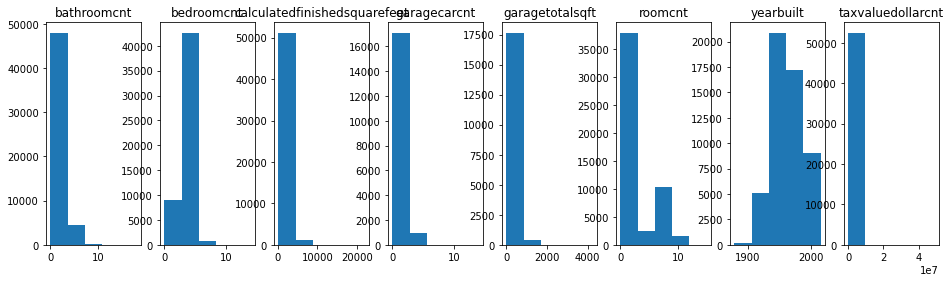

In [54]:
plt.figure(figsize=(16, 9))

# List of columns
cols = [col for col in df.columns if col not in ['fips', 'poolcnt']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(2, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
plt.show()

In [5]:
### Looking at outliers

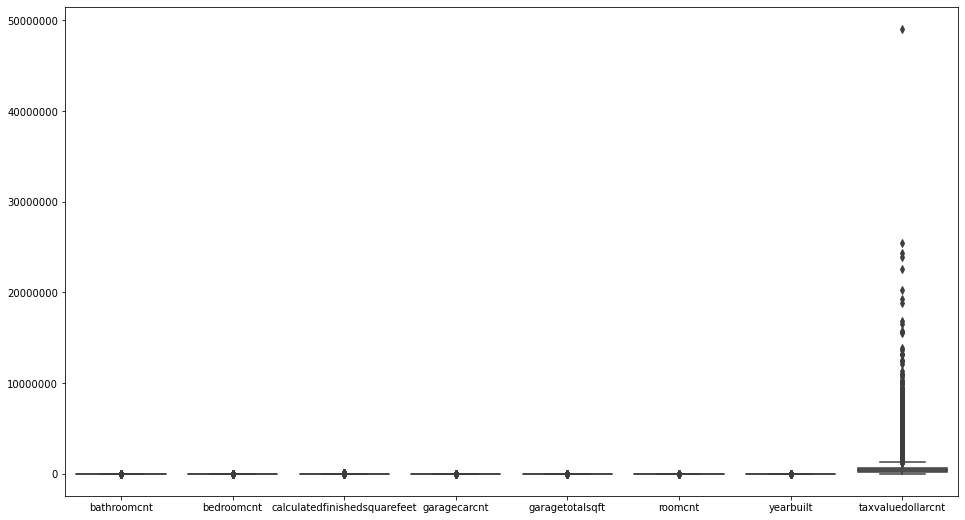

In [6]:
plt.figure(figsize=(16,9))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=df.drop(columns=['fips', 'poolcnt']))

plt.show()

In [7]:
### Looking at outliers closer!

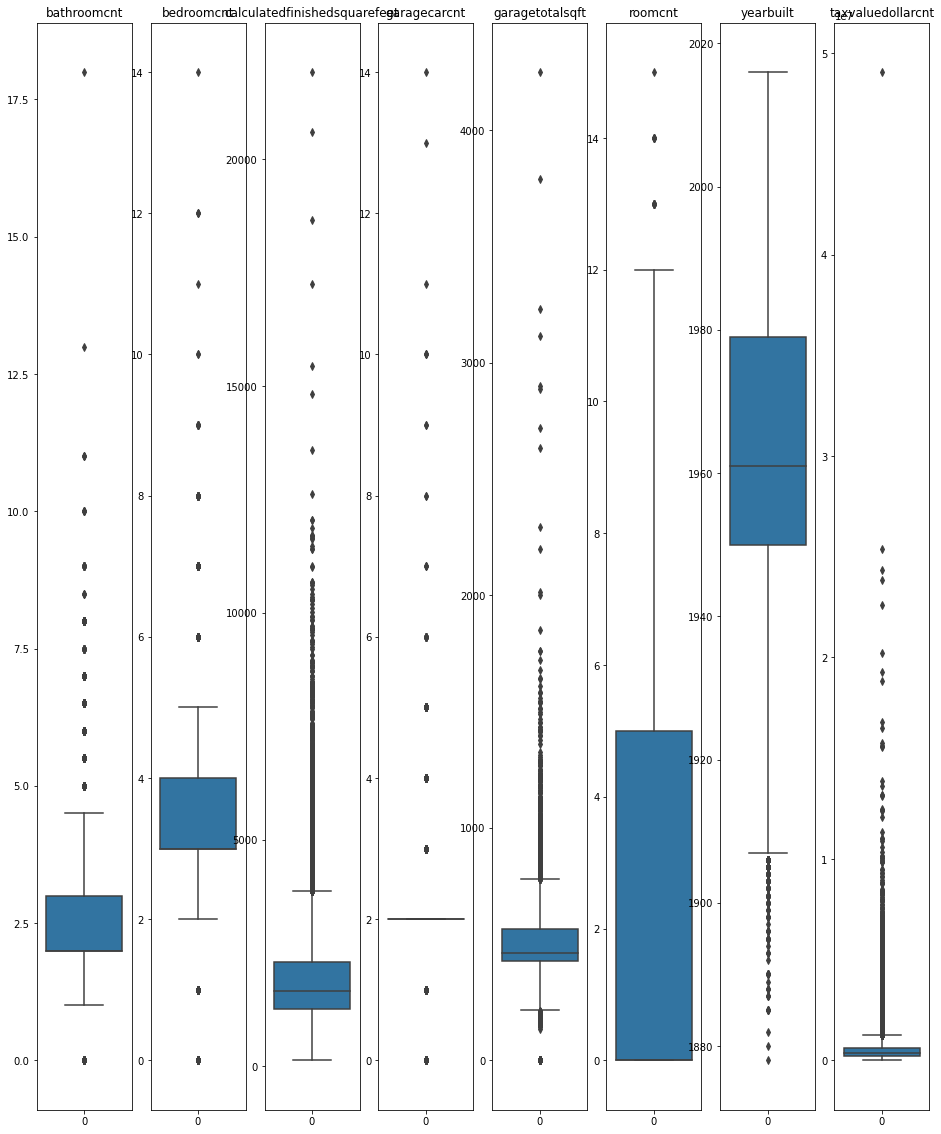

In [8]:
# List of columns
cols = [col for col in df.columns if col not in ['fips', 'poolcnt']]
plt.figure(figsize=(16, 20))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

# Prep Data using acquires prepare_zillow function

In [10]:
# Fill pools, garage and garage count with 0s
# Drop all nulls
# Change yearbuilt to age yearbuilt_age function
# Rename columns for readability
# Remove Outliers using quartile Outlier function

In [11]:
train, validate, test = acquire.prepare_zillow(df)

# Exploration 2.0

## 1)Does being in Orange county effect tax value of a home vs other counties?

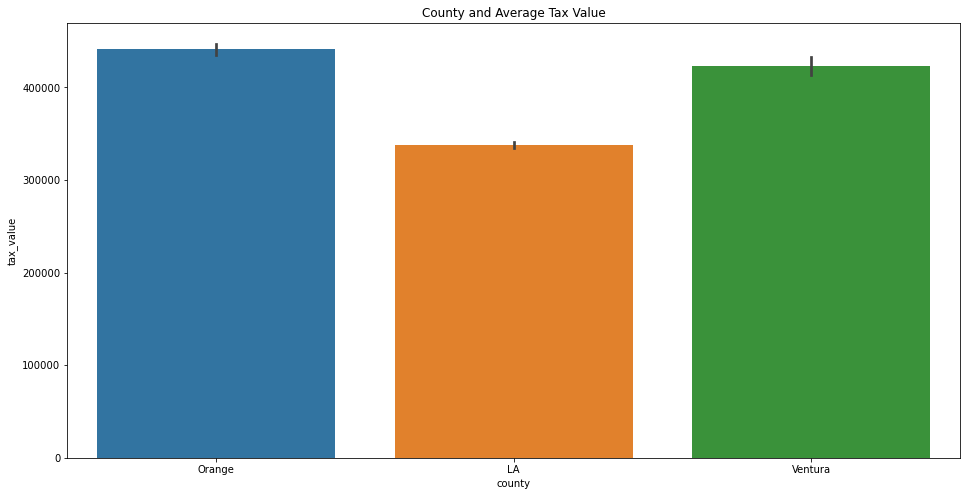

In [12]:
plt.figure(figsize=(16,8))
sns.barplot(x = 'county', y = 'tax_value', data = train)
plt.title("County and Average Tax Value")
plt.show()

## Closer look at Orange County

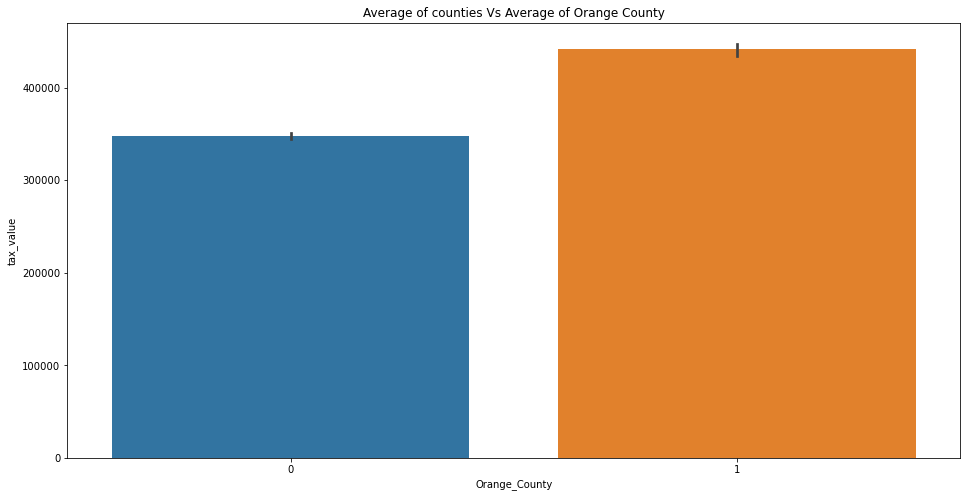

In [14]:
plt.figure(figsize=(16,8))
sns.barplot(y = 'tax_value', x = 'Orange_County', data = train)
plt.title("Average of counties Vs Average of Orange County")
plt.show()

# Statistical Test: t-test

H0: Mean of tax value of orange county == mean of tax values of all other counties
    
Ha: Mean of tax value of orange county != mean of tax value of all other counties

In [15]:
alpha = 0.01
sample = train[train.county == 'Orange'].tax_value
overall_mean = train.tax_value.mean()

t, p = stats.ttest_1samp(sample, overall_mean)

print(t, p/2, alpha)

22.28918277432004 1.5532616455130103e-106 0.01


In [16]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


#### P value is low, there is a relationship!

## 2)Does the age of the home effect the tax value of the home?

<Figure size 1152x576 with 0 Axes>

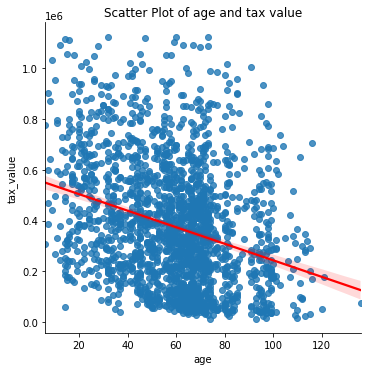

In [17]:
plt.figure(figsize=(16,8))
sns.lmplot(data = train.sample(2000), x = 'age', y = 'tax_value',line_kws={'color': 'red'})
plt.title("Scatter Plot of age and tax value")
plt.show()

## Pearsons R , finding a linear relationship between age and tax value

H0: There is not linear correlation between the tax value and the age of the house.

HA: There is linear correlation between the tax value and the age of the house.

In [18]:
test_results = stats.pearsonr(train.tax_value, train.age)
r, p = test_results
print("r: ", r, "p: ", p)

r:  -0.22784050801640257 p:  9.04901470162524e-298


### R indicating there is a negative linear correlation between the two

In [19]:
alpha = 0.01
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


#### P is low indicating a relationship, and r indicates a negative correlations relationship!

## 3)Does the area (in sqft) effect the tax value? (Is there a relationship?) 

<Figure size 1152x576 with 0 Axes>

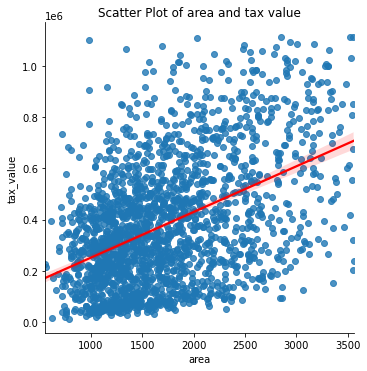

In [20]:
plt.figure(figsize=(16,8))
sns.lmplot(data = train.sample(2000), x = 'area', y = 'tax_value',line_kws={'color': 'red'})
plt.title("Scatter Plot of area and tax value")
plt.show()

In [22]:
test_results = stats.pearsonr(train.tax_value, train.area)
r, p = test_results
print("r: ", r, "p: ", p)

r:  0.4403937830902459 p:  0.0


H0: There is not linear correlation between the tax value and the area of the house.

HA: There is linear correlation between the tax value and the area of the house.

In [23]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


#### P is low indicating a relationship, and r indicates a positive correlations relationship!

## 4)Does the home with a pool effect the tax value?

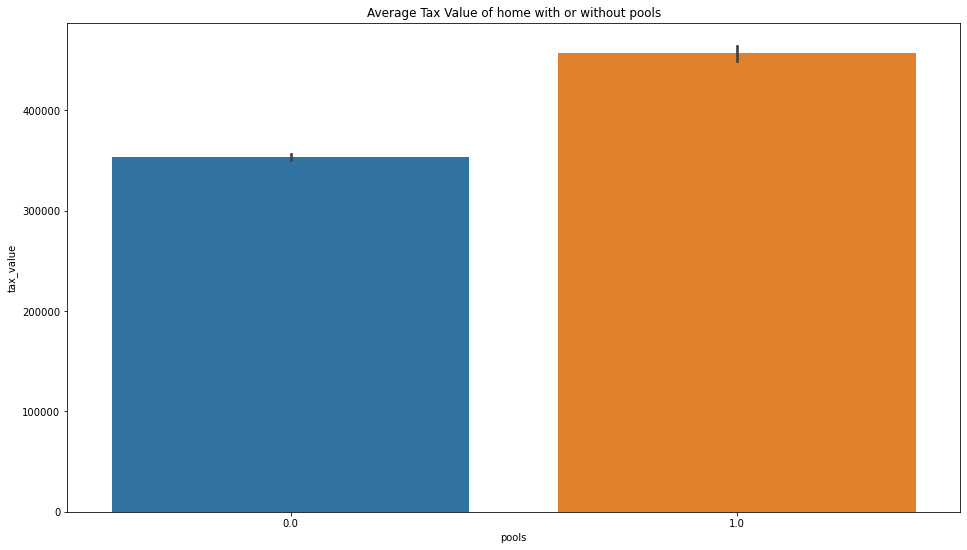

In [24]:
plt.figure(figsize=(16,9))
sns.barplot(data = train, x = 'pools', y = 'tax_value')
plt.title("Average Tax Value of home with or without pools")
plt.show()

In [25]:
alpha = 0.01
sample = train[train.pools == 1].tax_value
overall_mean = train.tax_value.mean()

t, p = stats.ttest_1samp(sample, overall_mean)

print(t, p/2, alpha)

22.425522472499143 5.406113333408643e-106 0.01


H0: Mean of tax value of homes with pools == mean of tax values of all other homes
    
Ha: Mean of tax value of homes with pools != mean of tax value of all other homes

In [26]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


#### P Value is low indicating a relationship

# Creating Model

In [27]:
train.head()

,bathrooms,bedrooms,area,county,garages,garagetotalsqft,pools,roomcnt,tax_value,age,LA_County,Orange_County,Ventura_County
45337,2.5,3.0,1927.0,Orange,2.0,446.0,0.0,0.0,551076.0,18,0,1,0
45534,1.0,2.0,924.0,LA,0.0,0.0,0.0,0.0,319803.0,64,1,0,0
20230,1.0,3.0,1042.0,LA,0.0,0.0,0.0,0.0,855652.0,90,1,0,0
38945,1.0,2.0,1089.0,Ventura,1.0,360.0,0.0,5.0,40638.0,96,0,0,1
22988,2.0,4.0,1169.0,LA,0.0,0.0,0.0,0.0,182143.0,70,1,0,0


In [28]:
train = train.drop(columns = ['county'])
validate = validate.drop(columns = ['county'])
test = test.drop(columns = ['county'])

In [29]:
X_train = train.drop(columns = ['tax_value'])
y_train = train.tax_value

X_validate = validate.drop(columns = ['tax_value'])
y_validate = validate.tax_value

X_test = test.drop(columns = ['tax_value'])
y_test = test.tax_value

## Scaling The Data

In [30]:
# Robust Scaler for the outliers still in here even after using a outlier remover
scaler = sklearn.preprocessing.RobustScaler()

scaler.fit(X_train)

x_train_scaled = scaler.transform(X_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns = X_train.columns.to_list())


# Validate Scaler
scaler.fit(X_validate)

x_validate_scaled = scaler.transform(X_validate)
x_validate_scaled = pd.DataFrame(x_validate_scaled, columns = X_validate.columns.to_list())


# Test scaler
scaler.fit(X_test)

x_test_scaled = scaler.transform(X_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns = X_test.columns.to_list())

#### Finding Features via with Scaled Data

#### Select K Best

In [31]:
# SElect K best
f_selector = SelectKBest(f_regression, k=3)

# find top 3 correlated to target variable
f_selector.fit(x_train_scaled, y_train)

# bool mask of whether the columns was selected or not
feature_mask = f_selector.get_support()

# Get list of K features
f_feature = x_train_scaled.iloc[:,feature_mask].columns.tolist()

f_feature

['bathrooms', 'area', 'garagetotalsqft']

#### RFE

In [32]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 3)

# fit the data using RFE
rfe.fit(x_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = x_train_scaled.iloc[:,feature_mask].columns.tolist()

rfe_feature

['area', 'roomcnt', 'LA_County']

## Testing Baseline Accuracy

In [33]:
# Setting y_train to a data frame
y_train = pd.DataFrame(y_train)

y_train['baseline_mean'] = y_train['tax_value'].mean()
y_train['baseline_med'] = y_train['tax_value'].median()

# Baseline in validate
y_validate = pd.DataFrame(y_validate)

y_validate['baseline_mean'] = y_validate['tax_value'].mean()

# Baseline in test
y_test = pd.DataFrame(y_test)

y_test['baseline_mean'] = y_test['tax_value'].mean()

### Testing RMSE baseline values of median or mean for the best baseline!

In [34]:
# Test RMSE Value

rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_mean)**(1/2)
rmse_train2 = mean_squared_error(y_train.tax_value, y_train.baseline_med)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train2, 2))

RMSE using Median
Train/In-Sample:  246549.52


In [35]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2))

RMSE using Mean
Train/In-Sample:  243918.77


# Models (OLS / Laso R / and Polynomial)

### OLS Model

In [36]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm.fit(x_train_scaled, y_train.tax_value)

# predict train
y_train['tax_pred_lm'] = lm.predict(x_train_scaled)

# evaluate: rmse
rmse_train_ols = mean_squared_error(y_train.tax_value, y_train.tax_pred_lm)**(1/2)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_ols)

RMSE for OLS using LinearRegression
Training/In-Sample:  213014.01669734885


## Laso R

In [37]:
lars = LassoLars(alpha=1.0, random_state=123)

# fit the model to our training data. 
# since we have converted it to a dataframe from a series! 
lars.fit(x_train_scaled, y_train.tax_value)

# predict train
y_train['tax_pred_lars'] = lars.predict(x_train_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.tax_value, y_train.tax_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars) 

RMSE for Lasso + Lars
Training/In-Sample:  213015.9924506074


## Polynomial 

In [38]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(x_train_scaled)

In [39]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm2.fit(x_train_scaled, y_train.tax_value)

# predict train
y_train['tax_pred_lm2'] = lm2.predict(x_train_scaled)

# evaluate: rmse
rmse_train_poly = mean_squared_error(y_train.tax_value, y_train.tax_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_poly)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  213014.01669734885


# Plotting actual vs predicted

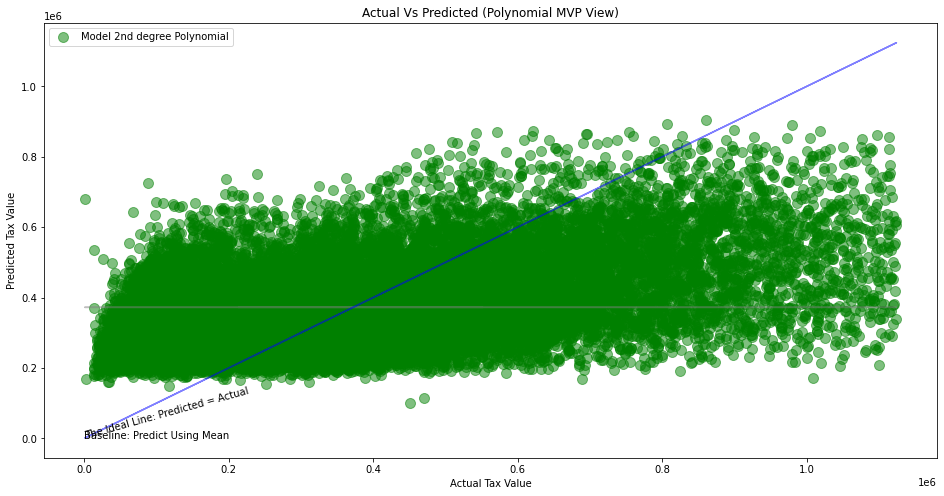

In [40]:
plt.figure(figsize=(16,8))
plt.plot(y_train.tax_value, y_train.baseline_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (4, 5))
plt.plot(y_train.tax_value, y_train.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

#plt.scatter(y_train.tax_value, y_train.tax_pred_lm, 
#            alpha=.5, color="red", s=100, label="Model: LinearRegression")
#plt.scatter(y_train.tax_value, y_train.tax_pred_lars, 
#           alpha=.5, color="yellow", s=100, label="Model: Lars R")
plt.scatter(y_train.tax_value, y_train.tax_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Actual Vs Predicted (Polynomial MVP View)")

plt.show()

# Plotting Residuals

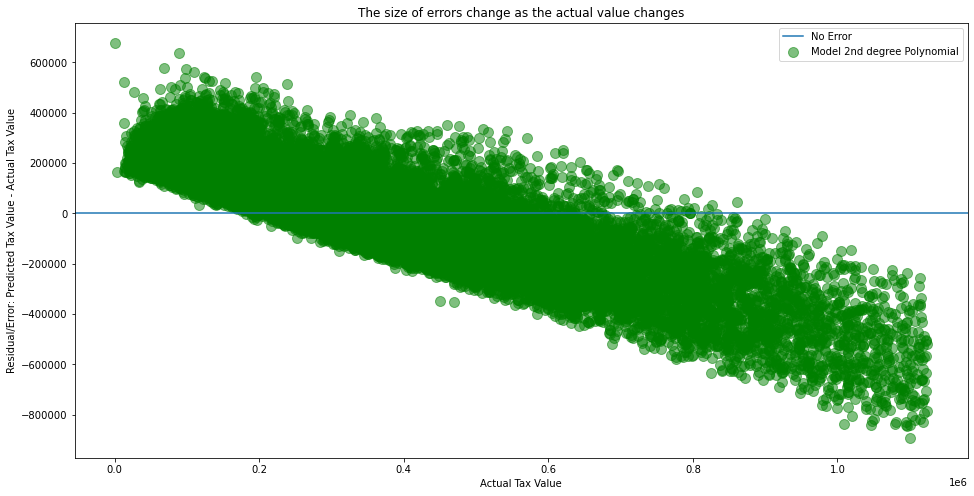

In [49]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
#plt.scatter(y_train.tax_value, y_train.tax_pred_lm - y_train.tax_value, 
#            alpha=.5, color="red", s=100, label="Model: LinearRegression")
#plt.scatter(y_train.tax_value, y_train.tax_pred_lars - y_train.tax_value, 
#            alpha=.5, color="yellow", s=100, label="Model: Lars")
plt.scatter(y_train.tax_value, y_train.tax_pred_lm2 - y_train.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("The size of errors change as the actual value changes")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Takaways as prices increase, the model is becoming less effective
### it is under predicting values at higher prices

# Modeling with validate samples

In [42]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our validate data.
# since we have converted it to a dataframe from a series! 
lm.fit(x_validate_scaled, y_validate.tax_value)

# predict train
y_validate['tax_pred_lm'] = lm.predict(x_validate_scaled)

# evaluate: rmse
rmse_validate_ols = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_validate_ols)

RMSE for OLS using LinearRegression
Training/In-Sample:  211553.6834447848


In [43]:
lars = LassoLars(alpha=1.0, random_state=123)

# fit the model to our validate data.
# since we have converted it to a dataframe from a series! 
lars.fit(x_validate_scaled, y_validate.tax_value)

# predict train
y_validate['tax_pred_lars'] = lars.predict(x_validate_scaled)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_validate_lars) 

RMSE for Lasso + Lars
Training/In-Sample:  211554.70770871785


### Best Performing is Polynomial

In [44]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_validate_degree2 = pf.fit_transform(x_validate_scaled)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our validate data.
# since we have converted it to a dataframe from a series! 
lm2.fit(X_validate_degree2, y_validate.tax_value)

# predict train
y_validate['tax_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_poly = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nValidate/In-Sample: ", rmse_validate_poly)

RMSE for Polynomial Model, degrees=2
Validate/In-Sample:  207486.2989174418


# Modeling with test data

In [45]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_test_scaled
X_test_degree2 = pf.fit_transform(x_test_scaled)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our test data. We must specify the column in y_test, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_test_degree2, y_test.tax_value)

# predict train
y_test['tax_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test_poly = mean_squared_error(y_test.tax_value, y_test.tax_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTest/In-Sample: ", rmse_test_poly)

RMSE for Polynomial Model, degrees=2
Test/In-Sample:  209826.25403637683


### Test Results (train, validate, test) VS Baseline

In [46]:
rmse_train_poly/243918.77

0.8732989949783235

13% better than baseline

In [47]:
rmse_validate_poly/243918.77

0.8506368694686424

nearly 15% better than baseline!

In [48]:
rmse_test_poly/243918.77

0.8602300431261475

14% better than baseline!

# Takeaways

Looking at our questions: 
- counties (orange county)
- looking at how age affects tax value 
- area and tax value
- if the number of pools effect tax value.

We see that these all visually and using both t-tests and Pearsons R tests that they all held a relationship with tax value.

Then after creating the models we see that the 2nd degree polynomial model perfomring the best through all stages of modeling
that we have a model that beats the baseline by 14%!

Using my model we'll be able to detect tax value of homes in california with a better accuracy than the baseline!

# Recommendations

I recommend that you use my model for most of the future data, seen in my report the model will start under predicting higher value homes so this may become a issue other wise if using the same criteria, it will before at better level than baseline!

# Next time

With more time I would like to create different models for each individual county/ bathroom count/ bedroom counts/ pools/ garages / garage sqft / roomcnt /
etc. Though my model beat baseline I believe there is a larger room for improvement!

Also for further research targets more features using RFE and taking a closer looking at the features EX: area, La County, and roomcnt and maybe inlcuding more columns to see what else it'll indicating having a strong relationship towards tax value!